🔹 Step 1: Setup & Imports

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # type: ignore

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

🔹 Step 2: Load & Explore C-MAPSS (FD001) Dataset

In [2]:
# Path to C-MAPSS dataset (upload to Colab or mount from Google Drive)
train_path = "C:/Users/T8554/Desktop/Datasets/train_FD001.txt"
test_path = "C:/Users/T8554/Desktop/Datasets/test_FD001.txt"
rul_path = "C:/Users/T8554/Desktop/Datasets/RUL_FD001.txt"

# Load data
col_names = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]
train_df = pd.read_csv(train_path, sep=" ", header=None)
train_df = train_df.drop([26,27], axis=1)  # drop empty columns
train_df.columns = col_names

test_df = pd.read_csv(test_path, sep=" ", header=None)
test_df = test_df.drop([26,27], axis=1)
test_df.columns = col_names

rul_df = pd.read_csv(rul_path, sep=" ", header=None)

In [20]:
print(train_df.head())
print(train_df.shape)

   unit  cycle     os1     os2    os3      s1      s2       s3       s4  \
0     1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1     1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2     1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3     1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4     1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739 

🔹 Step 3: Preprocess C-MAPSS Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Compute RUL for training set
rul_train = train_df.groupby("unit")["cycle"].max().reset_index()
rul_train.columns = ["unit", "max_cycle"]

train_df = train_df.merge(rul_train, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [f"s{i}" for i in range(1, 22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

joblib.dump(scaler, "scaler_fd001.pkl")  # Save scaler for future use

print(train_df[["unit", "cycle", "RUL"]].head())

   unit  cycle  RUL
0     1      1  191
1     1      2  190
2     1      3  189
3     1      4  188
4     1      5  187


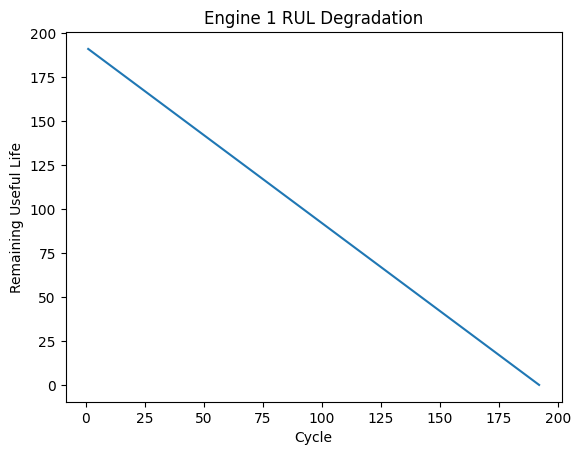

In [4]:
engine1 = train_df[train_df["unit"]==1]
plt.plot(engine1["cycle"], engine1["RUL"])
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title("Engine 1 RUL Degradation")
plt.show()

🔹 Step 4: Load & Explore XJTU-SY Bearing Dataset

In [23]:
import numpy as np
import pandas as pd
import os

# Example: load one training pair (x = signals, y = labels)
x_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/xtr1_1.npy"
y_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/ytr1_1.npy"

X = np.load(x_file)   # shape: (samples, time, channels)
y = np.load(y_file)   # shape: (samples, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# --- Feature Extraction (basic statistics from vibration signals) ---
# RMS = Root Mean Square per sample
rms = np.sqrt(np.mean(X**2, axis=(1, 2)))

# Mean amplitude
mean_val = np.mean(X, axis=(1, 2))

# Standard deviation
std_val = np.std(X, axis=(1, 2))

# Build DataFrame
features_df = pd.DataFrame({
    "rms": rms,
    "mean": mean_val,
    "std": std_val,
    "RUL": y.flatten()
})

print(features_df.head())

X shape: (123, 32768, 2)
y shape: (123, 1)
        rms      mean       std         RUL
0  0.319333  0.000215  0.319333  100.000000
1  0.326691 -0.002130  0.326684   99.180328
2  0.327543  0.002202  0.327536   98.360656
3  0.329079  0.003865  0.329057   97.540984
4  0.335730 -0.002841  0.335718   96.721311


In [24]:
# data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"

# features_all = []

# for file in os.listdir(data_dir):
#     if file.startswith("xtr"):   # training files only
#         x_file = os.path.join(data_dir, file)
#         y_file = os.path.join(data_dir, "y" + file[1:])  # replace 'x' with 'y'

#         X = np.load(x_file)
#         y = np.load(y_file)

#         rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
#         mean_val = np.mean(X, axis=(1, 2))
#         std_val = np.std(X, axis=(1, 2))

#         df = pd.DataFrame({
#             "rms": rms,
#             "mean": mean_val,
#             "std": std_val,
#             "RUL": y.flatten()
#         })
#         features_all.append(df)

# # Final combined dataset
# final_df = pd.concat(features_all, ignore_index=True)
# print(final_df.head())
# print(final_df.shape)

🔹 Step 5: Feature Extraction + Dataset Assembly (XJTU-SY)

Final dataset shape: (9214, 6)
        rms      mean       std       max       min         RUL
0  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000
1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328
2  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656
3  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984
4  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311
Random Forest RUL Prediction RMSE: 2.2701382241737784
Random Forest Health Stage Accuracy: 1.0
Random Forest Health Stage F1-score: 1.0

Classification Report:

              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00       586
     Healthy       1.00      1.00      1.00       515
     Warning       1.00      1.00      1.00       742

    accuracy                           1.00      1843
   macro avg       1.00      1.00      1.00      1843
weighted avg       1.00      1.00      1.00      1843



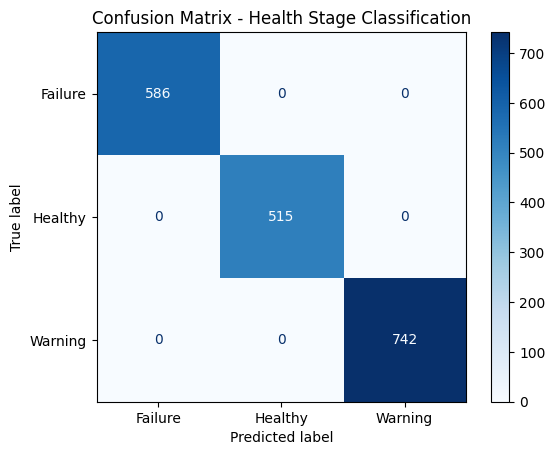

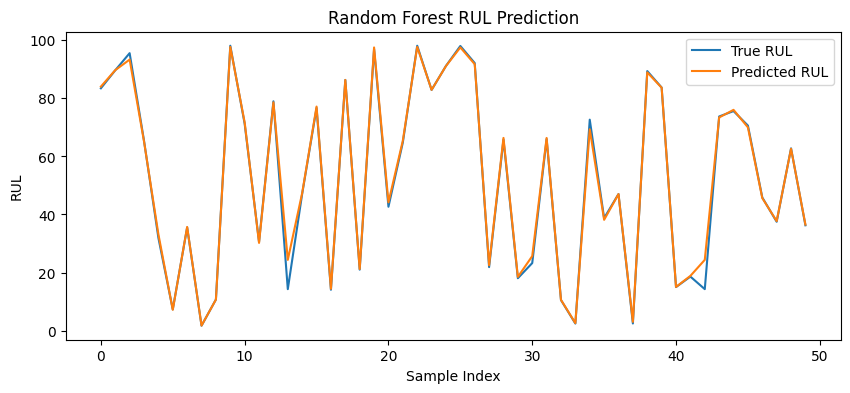

In [25]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Path to dataset
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"

features_all = []

# Loop through training files
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training files only
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # replace 'x' with 'y'

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        df = pd.DataFrame({
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })
        features_all.append(df)

# Final combined dataset
final_df = pd.concat(features_all, ignore_index=True)
print("Final dataset shape:", final_df.shape)
print(final_df.head())

# --- Define Health Stages from RUL ---
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

# --- Features & Labels ---
X_features = final_df[["rms", "mean", "std", "max", "min"]]
y_rul = final_df["RUL"]                     # Regression target (Remaining Useful Life)
y_health = final_df["health_stage"]         # Classification target

# --- Train-Test Split (single split for both tasks) ---
X_train, X_test, y_train_rul, y_test_rul, y_train_cls, y_test_cls = train_test_split(
    X_features, y_rul, y_health, test_size=0.2, random_state=42
)

# --- Baseline 1: Random Forest for RUL (Regression) ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("Random Forest RUL Prediction RMSE:", rmse)

# --- Baseline 2: Random Forest for Health Stage (Classification) ---
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("Random Forest Health Stage Accuracy:", acc)
print("Random Forest Health Stage F1-score:", f1)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# --- Visualization of RUL Predictions ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul.values[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction")
plt.show()

🔹 Step 6: Preprocess FD001 (save CSV)

In [5]:
import numpy as np
import pandas as pd

# ------------------------------
# Paths (update as per your folder)
# ------------------------------
train_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/train_FD001.txt"
test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
rul_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

# ------------------------------
# Column Names
# ------------------------------
col_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]  # 21 sensors

# ------------------------------
# Load Training Data
# ------------------------------
train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
train_df.columns = col_names

# Create RUL (max cycle - current cycle)
rul_df = train_df.groupby("unit_number")["time_in_cycles"].max().reset_index()
rul_df.columns = ["unit_number", "max_cycle"]

train_df = train_df.merge(rul_df, on="unit_number", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["time_in_cycles"]

# ------------------------------
# Save Preprocessed Data
# ------------------------------
out_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
train_df.to_csv(out_file, index=False)

print("✅ Preprocessed data saved to:", out_file)
print(train_df.head())

✅ Preprocessed data saved to: C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv
   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4 

🔹 Step 7: Train Random Forest on Preprocessed CSV

✅ Random Forest RMSE on Validation: 41.40888285948394


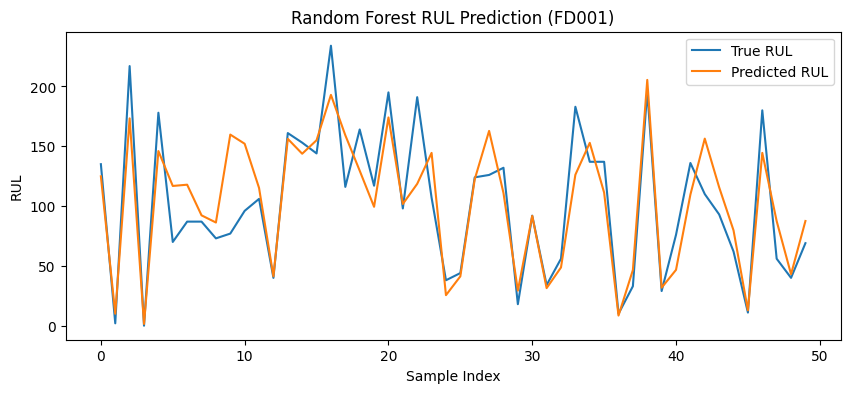

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ------------------------------
# Load Preprocessed Data
# ------------------------------
df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# Feature columns (sensors only for now)
sensor_cols = [c for c in df.columns if "sensor" in c]
X = df[sensor_cols]
y = df["RUL"]

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ------------------------------
# Baseline Model - Random Forest
# ------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred))
print("✅ Random Forest RMSE on Validation:", rmse_rf)

# ------------------------------
# Plot Predictions
# ------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_val.values[:50], label="True RUL")
plt.plot(y_pred[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction (FD001)")
plt.show()

🔹 Step 8: Evaluate on Test Set (FD001)

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ------------------------------
# Load Preprocessed Training Data
# ------------------------------
train_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# Sensor features
sensor_cols = [c for c in train_df.columns if "sensor" in c]
X_train = train_df[sensor_cols]
y_train = train_df["RUL"]

# Normalize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ------------------------------
# Train Random Forest (full training data)
# ------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# ------------------------------
# Load Test Data + RUL Truth
# ------------------------------
test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
rul_file  = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

col_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
test_df.columns = col_names

rul_truth = pd.read_csv(rul_file, delim_whitespace=True, header=None)

# ------------------------------
# For each engine in test set → last cycle
# ------------------------------
test_rul = test_df.groupby("unit_number").last().reset_index()

# Add true RUL from RUL_FD001.txt
test_rul["true_RUL"] = rul_truth[0]

# Features
X_test = test_rul[sensor_cols]
X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(test_rul["true_RUL"], y_pred))
print("✅ Random Forest RMSE on Test FD001:", rmse_test)

# Compare few predictions
comparison = pd.DataFrame({
    "Engine": test_rul["unit_number"],
    "True RUL": test_rul["true_RUL"],
    "Predicted RUL": y_pred.round(1)
})
print(comparison.head(10))

✅ Random Forest RMSE on Test FD001: 34.640025765001965
   Engine  True RUL  Predicted RUL
0       1       112          170.8
1       2        98          145.5
2       3        69           59.8
3       4        82          119.6
4       5        91          125.0
5       6        93          124.5
6       7        91          132.6
7       8        95          112.1
8       9       111          128.1
9      10        96          129.7


In [9]:
import joblib

# Save Random Forest Regressor (NASA FD001)
joblib.dump(rf, "rf_rul_fd001.pkl")

# # Save Random Forest Classifier (XJTU-SY)
# joblib.dump(rf_cls, "rf_health_xjtu.pkl")

print("✅ Random Forest models saved!")

✅ Random Forest models saved!


🔹 Step 9: XJTU-SY Preprocessing Script

In [29]:
import numpy as np
import pandas as pd
import os

# ------------------------------
# Paths (update to your system)
# ------------------------------
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"
output_csv = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"

features_all = []

# ------------------------------
# Loop through training files
# ------------------------------
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training vibration signals
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # matching RUL labels

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        # Load signals (X) and RUL (y)
        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        # DataFrame for this file
        df = pd.DataFrame({
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })

        features_all.append(df)

# ------------------------------
# Combine all into one dataset
# ------------------------------
final_df = pd.concat(features_all, ignore_index=True)

# Define Health Stages from RUL
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

print("Final dataset shape:", final_df.shape)
print(final_df.head())

# Save to CSV
final_df.to_csv(output_csv, index=False)
print(f"✅ Preprocessed dataset saved to {output_csv}")

Final dataset shape: (9214, 7)
        rms      mean       std       max       min         RUL health_stage
0  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000      Healthy
1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328      Healthy
2  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656      Healthy
3  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984      Healthy
4  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311      Healthy
✅ Preprocessed dataset saved to C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv


🔹 Step 10: Baseline ML Models on XJTU-SY

Dataset shape: (9214, 7)
        rms      mean       std       max       min         RUL health_stage
0  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000      Healthy
1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328      Healthy
2  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656      Healthy
3  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984      Healthy
4  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311      Healthy

🔹 Random Forest Classifier Results:
Accuracy: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

     Failure       1.00      1.00      1.00       586
     Healthy       1.00      1.00      1.00       515
     Warning       1.00      1.00      1.00       742

    accuracy                           1.00      1843
   macro avg       1.00      1.00      1.00      1843
weighted avg       1.00      1.00      1.00      1843



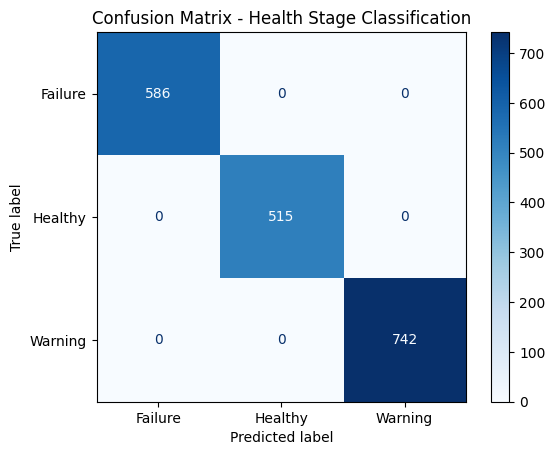


🔹 Random Forest Regressor Results:
RMSE (RUL prediction): 2.236672062871001


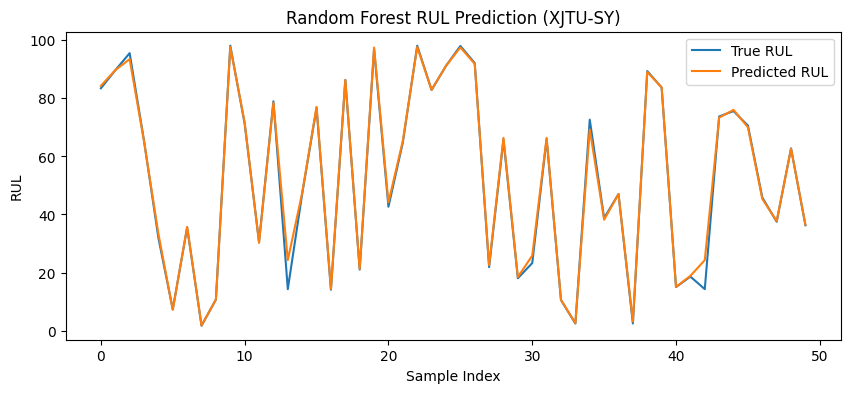

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
df = pd.read_csv(data_file)

print("Dataset shape:", df.shape)
print(df.head())

# ------------------------------
# Features and Targets
# ------------------------------
X = df[["rms", "mean", "std", "max", "min"]]
y_cls = df["health_stage"]   # classification labels
y_rul = df["RUL"]            # regression labels

# ------------------------------
# Train-Test Split
# ------------------------------
X_train, X_test, y_train_cls, y_test_cls, y_train_rul, y_test_rul = train_test_split(
    X, y_cls, y_rul, test_size=0.2, random_state=42
)

# ------------------------------
# Model 1: Random Forest Classifier
# ------------------------------
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc_xjtu = accuracy_score(y_test_cls, y_pred_cls)
f1_xjtu = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("\n🔹 Random Forest Classifier Results:")
print("Accuracy:", acc_xjtu)
print("F1-score:", f1_xjtu)
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# ------------------------------
# Model 2: Random Forest Regressor
# ------------------------------
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("\n🔹 Random Forest Regressor Results:")
print("RMSE (RUL prediction):", rmse)

# RUL Prediction Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul.values[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction (XJTU-SY)")
plt.show()

🔹 Step 11: Deep Learning Model for XJTU-SY (Autoencoder for Anomaly Detection)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1823 - val_loss: 0.1760
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1693 - val_loss: 0.1635
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1572 - val_loss: 0.1517
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 - val_loss: 0.1407
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 - val_loss: 0.1305
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1253 - val_loss: 0.1209
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1161 - val_loss: 0.1121
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1076 - val_loss: 0.1039
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0998 - val_loss: 0.0964
Epoch 10/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0926 - val_loss: 0.0894
Epoch 11/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0859 - val_loss: 0.0830
Epoch 12/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0797 - val_lo

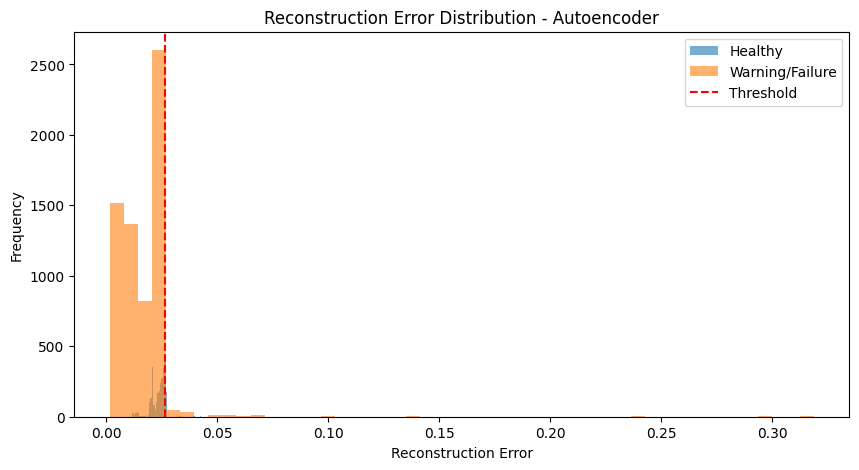


🔹 Autoencoder Anomaly Detection Report:

              precision    recall  f1-score   support

       False       0.28      0.88      0.42      2770
        True       0.30      0.02      0.04      6444

    accuracy                           0.28      9214
   macro avg       0.29      0.45      0.23      9214
weighted avg       0.29      0.28      0.16      9214



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
df = pd.read_csv(data_file)

# Features only
X = df[["rms", "mean", "std", "max", "min"]].values
y = df["health_stage"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# Split Healthy vs Others
# ------------------------------
X_healthy = X_scaled[y == "Healthy"]
X_nonhealthy = X_scaled[y != "Healthy"]

# Train/validation split (only healthy for training)
X_train, X_val = train_test_split(X_healthy, test_size=0.2, random_state=42)

# ------------------------------
# Define Autoencoder Model
# ------------------------------
input_dim = X_train.shape[1]
encoding_dim = 3  # compressed representation

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# ------------------------------
# Train Autoencoder
# ------------------------------
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, X_val),
    verbose=1
)

# ------------------------------
# Reconstruction Error
# ------------------------------
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

df["reconstruction_error"] = mse

# ------------------------------
# Threshold for Anomaly
# ------------------------------
threshold = np.percentile(mse, 95)  # top 5% as anomaly
df["predicted_anomaly"] = df["reconstruction_error"] > threshold

# ------------------------------
# Visualization
# ------------------------------
plt.figure(figsize=(10,5))
plt.hist(df["reconstruction_error"][y=="Healthy"], bins=50, alpha=0.6, label="Healthy")
plt.hist(df["reconstruction_error"][y!="Healthy"], bins=50, alpha=0.6, label="Warning/Failure")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution - Autoencoder")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# ------------------------------
# Evaluate Anomaly Detection
# ------------------------------
from sklearn.metrics import classification_report

y_true = (y != "Healthy")  # True if Warning/Failure
y_pred = df["predicted_anomaly"]

print("\n🔹 Autoencoder Anomaly Detection Report:\n")
print(classification_report(y_true, y_pred))

🔹 Step 12: LSTM Model for NASA C-MAPSS (FD001) – RUL Prediction

X_seq shape: (20581, 50, 21)
y_seq shape: (20581,)
Epoch 1/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 14010.7588

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 13106.4854 - val_loss: 16611.8672 - learning_rate: 0.0010
Epoch 2/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11914.3008

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 11403.8926 - val_loss: 14944.2578 - learning_rate: 0.0010
Epoch 3/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10336.8369

258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 10116.1758 - val_loss: 13543.7725 - learning_rate: 0.0010
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9345.3379

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 9016.8613 - val_loss: 12335.9385 - learning_rate: 0.0010
Epoch 5/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8352.5889

258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 8092.6611 - val_loss: 11295.0967 - learning_rate: 0.0010
Epoch 6/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7428.8613

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 7332.3125 - val_loss: 10400.2852 - learning_rate: 0.0010
Epoch 7/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6922.0034

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 6670.2148 - val_loss: 9634.9746 - learning_rate: 0.0010
Epoch 8/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6160.0312

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 6143.2241 - val_loss: 8985.2627 - learning_rate: 0.0010
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5840.8745

258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 5717.9482 - val_loss: 8440.2627 - learning_rate: 0.0010
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5484.6265

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 5362.6333 - val_loss: 7988.1880 - learning_rate: 0.0010
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5147.9482

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 5074.1704 - val_loss: 7614.7202 - learning_rate: 0.0010
Epoch 12/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4944.4888

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4865.4810 - val_loss: 7315.8271 - learning_rate: 0.0010
Epoch 13/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4782.0098

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4714.3560 - val_loss: 7076.9009 - learning_rate: 0.0010
Epoch 14/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4612.6099

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 4613.5303 - val_loss: 6892.1899 - learning_rate: 0.0010
Epoch 15/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4512.7402

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 4523.9575 - val_loss: 6751.2729 - learning_rate: 0.0010
Epoch 16/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4502.8672

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 4483.3013 - val_loss: 6646.1216 - learning_rate: 0.0010
Epoch 17/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4463.5220

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 4457.4438 - val_loss: 6568.1714 - learning_rate: 0.0010
Epoch 18/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4368.4912

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 4431.9497 - val_loss: 6515.1655 - learning_rate: 0.0010
Epoch 19/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4489.0479

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 4431.6914 - val_loss: 6476.9980 - learning_rate: 0.0010
Epoch 20/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4431.7793

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 4430.9863 - val_loss: 6452.6787 - learning_rate: 0.0010
Epoch 21/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4445.8730

258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 4436.9409 - val_loss: 6434.9980 - learning_rate: 0.0010
Epoch 22/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4473.0254

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4415.2896 - val_loss: 6426.3794 - learning_rate: 0.0010
Epoch 23/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4360.4800

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 4416.7354 - val_loss: 6419.9370 - learning_rate: 0.0010
Epoch 24/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4468.5776

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 4421.9810 - val_loss: 6415.7363 - learning_rate: 0.0010
Epoch 25/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4410.1235

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 4427.2065 - val_loss: 6411.7886 - learning_rate: 0.0010
Epoch 26/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4362.0635

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 4429.2041 - val_loss: 6409.0879 - learning_rate: 0.0010
Epoch 27/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 4421.3838 - val_loss: 6410.6841 - learning_rate: 0.0010
Epoch 28/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 4441.6470 - val_loss: 6426.1167 - learning_rate: 0.0010
Epoch 29/100
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3809.9590

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 3173.2656 - val_loss: 4219.3154 - learning_rate: 0.0010
Epoch 30/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2229.6248

258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 2162.0396 - val_loss: 3567.9893 - learning_rate: 0.0010
Epoch 31/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1911.2456

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 1843.9186 - val_loss: 3321.4976 - learning_rate: 0.0010
Epoch 32/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1660.9597

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 1620.5654 - val_loss: 3194.8804 - learning_rate: 0.0010
Epoch 33/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1618.3702

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 1497.0247 - val_loss: 2677.0483 - learning_rate: 0.0010
Epoch 34/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1374.3937

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1383.5857 - val_loss: 2472.0586 - learning_rate: 0.0010
Epoch 35/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1330.2307

258/258 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1297.5635 - val_loss: 2459.3801 - learning_rate: 0.0010
Epoch 36/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1241.7128

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 1245.5409 - val_loss: 2190.1484 - learning_rate: 0.0010
Epoch 37/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1174.9540

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 1208.5359 - val_loss: 2120.4150 - learning_rate: 0.0010
Epoch 38/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1151.9833

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 1176.2803 - val_loss: 2039.5387 - learning_rate: 0.0010
Epoch 39/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 1150.0670 - val_loss: 2228.9839 - learning_rate: 0.0010
Epoch 40/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1125.7430 - val_loss: 2102.7014 - learning_rate: 0.0010
Epoch 41/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1089.8671 - val_loss: 2103.6470 - learning_rate: 0.0010
Epoch 42/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1092.6895

258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 1087.7102 - val_loss: 1975.8555 - learning_rate: 0.0010
Epoch 43/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1138.8577

258/258 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 1083.5294 - val_loss: 1920.4664 - learning_rate: 0.0010
Epoch 44/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1075.7352 - val_loss: 2008.5243 - learning_rate: 0.0010
Epoch 45/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1056.2177 - val_loss: 1996.6060 - learning_rate: 0.0010
Epoch 46/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 1035.0597 - val_loss: 2052.8413 - learning_rate: 0.0010
Epoch 47/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1030.2002 - val_loss: 1968.5005 - learning_rate: 0.0010
Epoch 48/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1028.7220 - val_loss: 1960.8009 - learning_rate: 0.0010
Epoch 49/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1024.1699 - val_loss: 2070.0176 - learning_rate: 5.0000e-04
Epoch 50/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 992.4530 - val_loss: 1925.1094 - learning_rate: 5.0000e-04
Epoch 51/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms

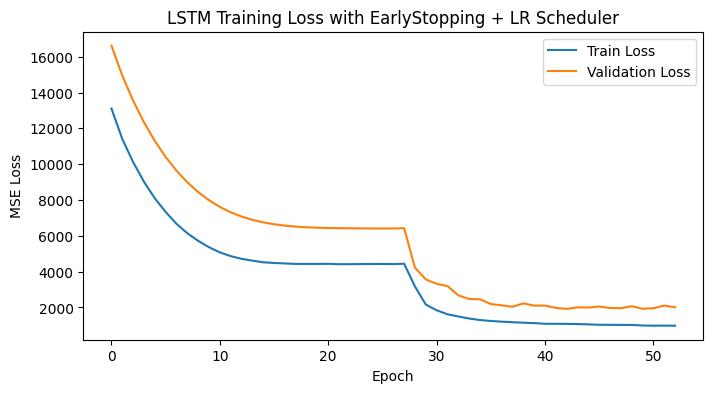

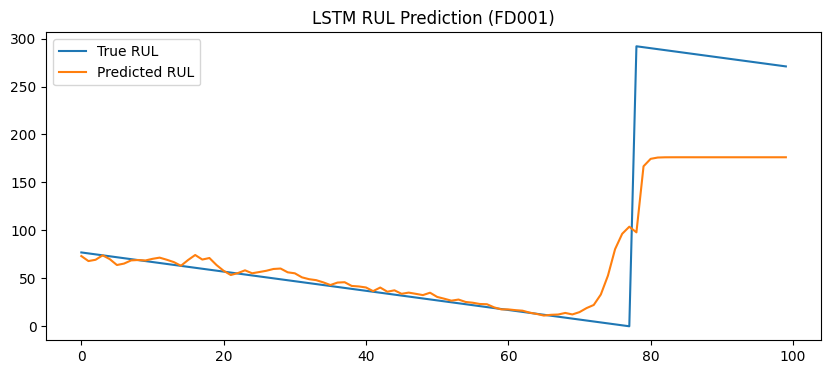

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.get_logger().setLevel("ERROR")

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
df = pd.read_csv(data_file)

# Features and target
sensor_cols = [c for c in df.columns if "sensor" in c]
X = df[sensor_cols].values
y = df["RUL"].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# Sequence Generator (last 50 cycles → RUL)
# ------------------------------
def create_sequences(X, y, seq_length=50):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 50
X_seq, y_seq = create_sequences(X_scaled, y, seq_length=SEQ_LEN)

print("X_seq shape:", X_seq.shape)  # (samples, seq_len, features)
print("y_seq shape:", y_seq.shape)

# Train/Validation Split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

# ------------------------------
# Build LSTM Model
# ------------------------------
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# ------------------------------
# Callbacks (EarlyStopping + LR Scheduler + Model Save)
# ------------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint("best_lstm_fd001.h5", monitor="val_loss", save_best_only=True)

# ------------------------------
# Train Model
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          # upper cap
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# ------------------------------
# Evaluate Model
# ------------------------------
y_pred = model.predict(X_val)
rmse_lstm = np.sqrt(mean_squared_error(y_val, y_pred))
print("LSTM RUL Prediction RMSE:", rmse_lstm)

# ------------------------------
# Plot Training Loss
# ------------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("LSTM Training Loss with EarlyStopping + LR Scheduler")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# ------------------------------
# Plot Predictions
# ------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_val[:100], label="True RUL")
plt.plot(y_pred[:100], label="Predicted RUL")
plt.legend()
plt.title("LSTM RUL Prediction (FD001)")
plt.show()

🔹 Step 13: Save & Compare Models (RF + LSTM + Autoencoder)

In [33]:
# 1️⃣ Save Random Forest Models (NASA & XJTU-SY)

import joblib

# Save Random Forest Regressor (NASA FD001)
joblib.dump(rf, "rf_rul_fd001.pkl")

# Save Random Forest Classifier (XJTU-SY)
joblib.dump(rf_cls, "rf_health_xjtu.pkl")

print("✅ Random Forest models saved!")


# 2️⃣ Save LSTM Model (NASA FD001 RUL)

# Save trained LSTM model
model.save("lstm_rul_fd001.keras")
print("✅ LSTM RUL model saved!")


# 3️⃣ Save Autoencoder Model (XJTU-SY)

# Save Autoencoder
autoencoder.save("autoencoder_xjtu.keras")
print("✅ Autoencoder model saved!")

# 4️⃣ Model Comparison (Table Format)

# You can quickly compare all models with their performance:

import pandas as pd

results = pd.DataFrame([
    {"Model": "Random Forest (RUL - NASA)", "Metric": "RMSE", "Score": rmse_rf},
    {"Model": "LSTM (RUL - NASA)", "Metric": "RMSE", "Score": rmse_lstm},
    {"Model": "Random Forest (Health - XJTU)", "Metric": "Accuracy", "Score": acc_xjtu},
    {"Model": "Random Forest (Health - XJTU)", "Metric": "F1-score", "Score": f1_xjtu},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (mean)", "Score": mse.mean()},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (95th %ile)", "Score": np.percentile(mse, 95)},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (max)", "Score": mse.max()}
])

print("\n✅ Model Performance Comparison:")
print(results)


# 5️⃣ Reload Later for Predictions

# Load RF
rf_loaded = joblib.load("rf_rul_fd001.pkl")

# Load LSTM
from tensorflow.keras.models import load_model # type: ignore
lstm_loaded = load_model("lstm_rul_fd001.keras")

# Load Autoencoder
autoencoder_loaded = load_model("autoencoder_xjtu.keras")

✅ Random Forest models saved!
✅ LSTM RUL model saved!
✅ Autoencoder model saved!

✅ Model Performance Comparison:
                           Model                            Metric      Score
0     Random Forest (RUL - NASA)                              RMSE  41.408883
1              LSTM (RUL - NASA)                              RMSE  43.823127
2  Random Forest (Health - XJTU)                          Accuracy   1.000000
3  Random Forest (Health - XJTU)                          F1-score   1.000000
4   Autoencoder (Anomaly - XJTU)       Reconstruction Error (mean)   0.018505
5   Autoencoder (Anomaly - XJTU)  Reconstruction Error (95th %ile)   0.026432
6   Autoencoder (Anomaly - XJTU)        Reconstruction Error (max)   0.318864
